In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

<h2> Menggunakan Canny edge detector </h2>
<hr />
1. Konversi ke grayscale <br>
2. Blur menggunakan gaussian blur <br>
3. Gunakan canny edge detector <br>

In [2]:
def canny_edge_detector(frame):
    
    # Convert to grayscale as only image intensity needed for gradients
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    # 5x5 gaussian blur to reduce noise 
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Canny edge detector with minVal of 50 and maxVal of 150
    canny = cv2.Canny(blur, 50, 150)
    
    return canny

<h2> Menggunakan ROI Mask untuk mendeteksi marka jalan </h2>
<hr />

In [3]:
def ROI_mask(image):
    
    height = image.shape[0]
    width = image.shape[1]

    
    # A triangular polygon to segment the lane area and discarded other irrelevant parts in the image
    # Defined by three (x, y) coordinates    
    polygons = np.array([ 
        [(150, height), (round(width/2), round(height/1.85)), (width, height)] 
        ]) 
    
    mask = np.zeros_like(image) 
    cv2.fillPoly(mask, polygons, 255)  ## 255 is the mask color
    
    # Bitwise AND between canny image and mask image
    masked_image = cv2.bitwise_and(image, mask)
    
    return masked_image

<h2> Mendapatkan koordinat ROI </h2>
<hr />

In [4]:
def get_coordinates (image, params):
     
    slope, intercept = params 
    y1 = image.shape[0]     
    y2 = int(y1 * (3/5)) # Setting y2 at 3/5th from y1
    x1 = int((y1 - intercept) / slope) # Deriving from y = mx + c
    x2 = int((y2 - intercept) / slope) 
    
    return np.array([x1, y1, x2, y2])

def avg_lines(image, lines): 
    
    left = [] 
    right = [] 
    
    for line in lines: 
        x1, y1, x2, y2 = line.reshape(4)
          
        # Fit polynomial, find intercept and slope 
        params = np.polyfit((x1, x2), (y1, y2), 1)  
        slope = params[0] 
        y_intercept = params[1] 
        
        if slope < 0: 
            left.append((slope, y_intercept)) #Negative slope = left lane
        else: 
            right.append((slope, y_intercept)) #Positive slope = right lane
    
    # Avg over all values for a single slope and y-intercept value for each line
    
    left_avg = np.average(left, axis = 0) 
    right_avg = np.average(right, axis = 0) 
    
    # Find x1, y1, x2, y2 coordinates for left & right lines
    left_line = get_coordinates(image, left_avg) 
    right_line = get_coordinates(image, right_avg)
    
    return np.array([left_line, right_line])

<h2> Menggabungkan gambar </h2>
<hr />

In [5]:
def draw_lines(image, lines, thickness): 
   
    print(lines)
    line_image = np.zeros_like(image)
    color=[0, 0, 255]
    
    if lines is not None: 
        for x1, y1, x2, y2 in lines:
                    cv2.line(line_image, (x1, y1), (x2, y2), color, thickness)

            
    # Merge the image with drawn lines onto the original.
    combined_image = cv2.addWeighted(image, 0.8, line_image, 1.0, 0.0)
    
    return combined_image

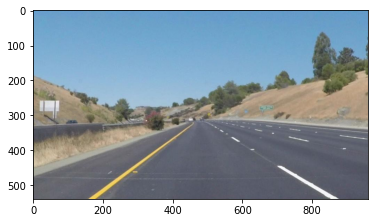

In [6]:
inputimage = cv2.imread("lane-detection-using-machine-learning.webp")

plt.figure()
plt.imshow(cv2.cvtColor(inputimage, cv2.COLOR_BGR2RGB))

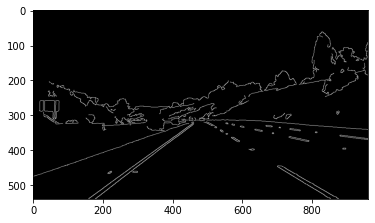

In [7]:
canny_edges = canny_edge_detector(inputimage)
plt.figure()
plt.imshow(cv2.cvtColor(canny_edges, cv2.COLOR_BGR2RGB))
plt.show()

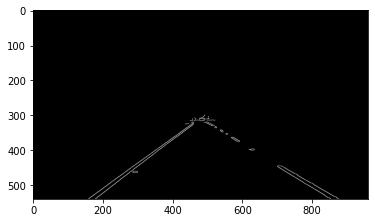

In [8]:
cropped_image = ROI_mask(canny_edges)
plt.figure()
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.show()

<h2> Hough Transfrom </h2>
<hr>

In [9]:
def Hough(input):
    lines = cv2.HoughLinesP(
    input,
    rho=2,              #Distance resolution in pixels
    theta=np.pi / 180,  #Angle resolution in radians
    threshold=100,      #Min. number of intersecting points to detect a line  
    lines=np.array([]), #Vector to return start and end points of the lines indicated by [x1, y1, x2, y2] 
    minLineLength=40,   #Line segments shorter than this are rejected
    maxLineGap=25       #Max gap allowed between points on the same line
    )
    return lines

[[169 540 458 324]
 [867 540 501 324]]


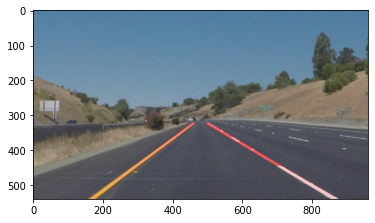

In [10]:
lines = Hough(cropped_image)

# Visualisations
averaged_lines = avg_lines (inputimage, lines)              #Average the Hough lines as left or right lanes
combined_image = draw_lines(inputimage, averaged_lines, 5)  #Combine the averaged lines on the real frame
plt.figure()
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
plt.show()

<h2> Mencoba pada file video </h2>
<hr />

In [11]:
video = cv2.VideoCapture("IMG_0264.MOV")

In [12]:
cap = video
   
# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video  file")
   
# Read until video is completed
while(cap.isOpened()):
      
  # Capture frame-by-frame
  ret, frame = cap.read()
  sue  = frame
  sue = canny_edge_detector(sue)
  sue = ROI_mask(sue)
  frame = sue
  #lines = Hough(sue)
  # Visualisations  
  #averaged_lines = avg_lines (frame, lines)              #Average the Hough lines as left or right lanes
  #frame = draw_lines(frame, averaged_lines, 5)  

  if ret == True:
      
    # Display the resulting frame
  
  
    cv2.imshow('Frame', frame)
   
    # Press Q on keyboard to  exit
    if cv2.waitKey(20) & 0xFF == ord('q'):
      break
   
  # Break the loop
  else: 
    break
   
# When everything done, release 
# the video capture object
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

1080

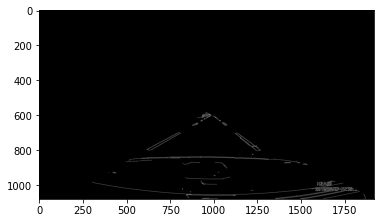

In [14]:
plt.imshow(frame, cmap="gray")
a = frame.shape
a[0]